# PDP Assignment #3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Load and prepare data.

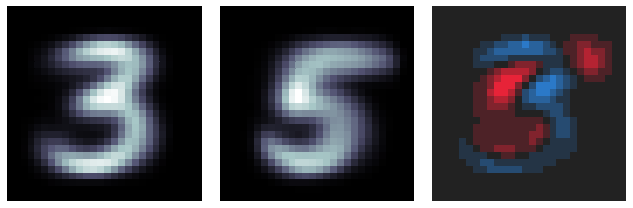

In [2]:
from sklearn.datasets import fetch_mldata

## Fetch MNIST dataset.
mnist = fetch_mldata("MNIST original")

## Extract data.
data = mnist['data'] / 255
target = mnist['target']

## Reduce to 3s and 5s.
ix = np.in1d(target, [3,5])
data = data[ix]
target = target[ix]

## Reduce to first 1000 3s and 5s.
ix = np.concatenate([np.where(target==i)[0][:1000] for i in [3,5]])
data = data[ix]
target = target[ix]

## Make average 3/5 image.
average_3_img = data[target==3].mean(axis=0).reshape(28,28)
average_5_img = data[target==5].mean(axis=0).reshape(28,28)

## Plot average images.
fig, axes = plt.subplots(1,3,figsize=(9,3))
for ax, img in zip(axes, [average_3_img, average_5_img]):
    sns.heatmap(img, cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
sns.heatmap(average_5_img-average_3_img, cmap=cmap, square=True, cbar=False, ax=axes[-1])
axes[-1].set(xticks=[], yticks=[])
plt.tight_layout()

## Logistic Regression
### Model fitting and performance

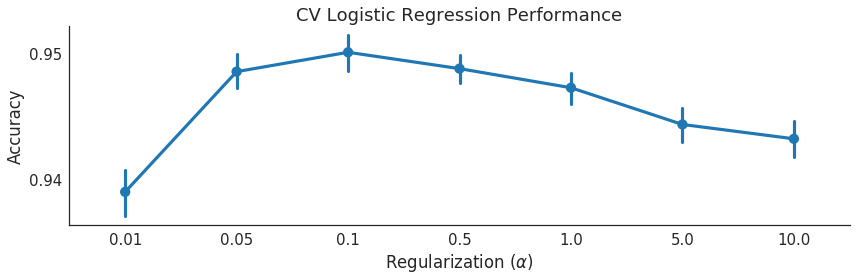

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit

## Define training parameters.
Cs = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.])
train_size = 0.5
test_size = 0.5
n_splits = 50

## Initialize scikit-learn objects.
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, 
                             train_size=train_size, random_state=0)
lrcv = LogisticRegressionCV(Cs=Cs, cv=cv, penalty='l2', random_state=0)

## Fit cross-validated model.
fit = lrcv.fit(data,target)
scores = DataFrame(fit.scores_[5], columns=fit.Cs_).melt()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.pointplot('variable','value',data=scores, ax=ax)
ax.set(xlabel=r'Regularization ($\alpha$)', ylabel='Accuracy', yticks=[0.94,0.95],
       title='CV Logistic Regression Performance')
sns.despine()
plt.tight_layout()

### Predictive weights

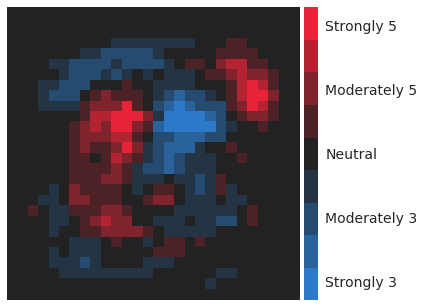

In [24]:
## Extract weights.
w = np.median(fit.coefs_paths_[5][:,Cs==0.1,:-1], axis=0)
w = w.reshape(28,28)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot heatmap.
sns.heatmap(w, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=ax, cbar_ax=cax)
ax.set(xticks=[], yticks=[])

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

## Neural Network


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Split data.
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5, test_size=0.5, 
                                                    stratify=target, random_state=0)

## Initialize network.
nn = MLPClassifier((30), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.01, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Score.
fit.score(X_test, y_test)

0.942

In [107]:
## Initialize network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=0.001, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

fit.score(X_test, y_test)

0.946

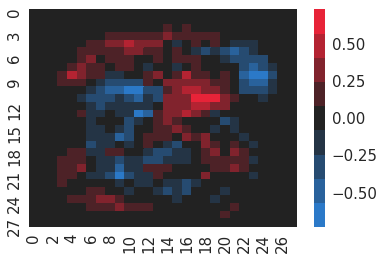

In [108]:
sns.heatmap(fit.coefs_[0].reshape(28,28), cmap=cmap)